In [ ]:
# BUSINESS SCIENCE UNIVERSITY
# PYTHON FOR GENERATIVE AI COURSE
# MULTI-AGENTS (AGENTIAL SUPERVISION)
# ***

# NOTE: requires yfinance to get the SPY data
# NOTE: Requires Tavily API Key for Web Search (add to credentials.yml file)

In [ ]:
# * LIBRARIES

from langchain.agents import AgentExecutor, create_openai_tools_agent
from langchain_core.messages import BaseMessage, HumanMessage
from langchain_openai import ChatOpenAI

from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_core.output_parsers.openai_functions import JsonOutputFunctionsParser

from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langgraph.graph import StateGraph, END

from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_experimental.tools import PythonREPLTool

import operator
import functools
import os
import yaml

import yfinance 

from typing import Annotated, Sequence, TypedDict

from pprint import pprint
from IPython.display import Image

In [ ]:
# * LLM SELECTION

MODEL = "gpt-4o-mini"
# MODEL = "gpt-3.5-turbo"
# MODEL = "gpt-4o"

In [ ]:
MODEL

'gpt-4o-mini'

In [ ]:
# * API KEYS

os.environ["OPENAI_API_KEY"] = yaml.safe_load(open('../credentials.yml'))['openai']

os.environ["TAVILY_API_KEY"] = yaml.safe_load(open("../credentials.yml"))['tavily']

In [ ]:
# * Create tools

tavily_tool = TavilySearchResults(max_results=5)

python_repl_tool = PythonREPLTool()

In [ ]:
# * Create Agent Supervisor

subagent_names = ["Researcher", "Coder"]

system_prompt = (
    "You are a supervisor tasked with managing a conversation between the following workers:  {subagent_names}. Given the following user request, respond with the worker to act next. Each worker will perform a task and respond with their results and status. When finished, respond with FINISH."
)

# Our team supervisor is an LLM node. It just picks the next agent to process and decides when the work is completed

# ['FINISH', 'Researcher', 'Coder']
route_options = ["FINISH"] + subagent_names 

# Using openai function calling can make output parsing easier for us
#  References: 
#   https://platform.openai.com/docs/guides/function-calling 
#   https://cookbook.openai.com/examples/how_to_call_functions_with_chat_models

function_def = {
    "name": "route",
    "description": "Select the next role.",
    "parameters": {
        "title": "route_schema",
        "type": "object",
        "properties": {
            "next": {
                "title": "Next",
                "anyOf": [
                    {"enum": route_options},
                ],
            }
        },
        "required": ["next"],
    },
}

prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system_prompt),
        MessagesPlaceholder(variable_name="messages"),
        (
            "system",
            "Given the conversation above, who should act next?"
            " Or should we FINISH? Select one of: {route_options}",
        ),
    ]
).partial(route_options=str(route_options), subagent_names=", ".join(subagent_names))

pprint(dict(prompt))

{'input_types': {'messages': typing.List[typing.Union[langchain_core.messages.ai.AIMessage, langchain_core.messages.human.HumanMessage, langchain_core.messages.chat.ChatMessage, langchain_core.messages.system.SystemMessage, langchain_core.messages.function.FunctionMessage, langchain_core.messages.tool.ToolMessage]]},
 'input_variables': ['messages'],
 'messages': [SystemMessagePromptTemplate(prompt=PromptTemplate(input_variables=['subagent_names'], template='You are a supervisor tasked with managing a conversation between the following workers:  {subagent_names}. Given the following user request, respond with the worker to act next. Each worker will perform a task and respond with their results and status. When finished, respond with FINISH.')),
              MessagesPlaceholder(variable_name='messages'),
              SystemMessagePromptTemplate(prompt=PromptTemplate(input_variables=['route_options'], template='Given the conversation above, who should act next? Or should we FINISH? Se

In [ ]:
llm = ChatOpenAI(model=MODEL)

In [ ]:
supervisor_chain = (
    prompt
    | llm.bind_functions(functions=[function_def], function_call="route")
    | JsonOutputFunctionsParser()
)

supervisor_chain

ChatPromptTemplate(input_variables=['messages'], input_types={'messages': typing.List[typing.Union[langchain_core.messages.ai.AIMessage, langchain_core.messages.human.HumanMessage, langchain_core.messages.chat.ChatMessage, langchain_core.messages.system.SystemMessage, langchain_core.messages.function.FunctionMessage, langchain_core.messages.tool.ToolMessage]]}, partial_variables={'route_options': "['FINISH', 'Researcher', 'Coder']", 'subagent_names': 'Researcher, Coder'}, messages=[SystemMessagePromptTemplate(prompt=PromptTemplate(input_variables=['subagent_names'], template='You are a supervisor tasked with managing a conversation between the following workers:  {subagent_names}. Given the following user request, respond with the worker to act next. Each worker will perform a task and respond with their results and status. When finished, respond with FINISH.')), MessagesPlaceholder(variable_name='messages'), SystemMessagePromptTemplate(prompt=PromptTemplate(input_variables=['route_opt

In [ ]:
# * SUBAGENTS

# * Helper function

def create_agent_with_tools(llm: ChatOpenAI, tools: list, system_prompt: str):
    # Each worker node will be given a name and some tools.
    prompt = ChatPromptTemplate.from_messages(
        [
            (
                "system",
                system_prompt,
            ),
            MessagesPlaceholder(variable_name="messages"),
            MessagesPlaceholder(variable_name="agent_scratchpad"),
        ]
    )
    agent = create_openai_tools_agent(llm, tools, prompt)
    executor = AgentExecutor(agent=agent, tools=tools)
    return executor

In [ ]:
# * Research Agent

researcher_agent = create_agent_with_tools(
    llm, 
    [tavily_tool], 
    "You are a web researcher."
)

In [ ]:
researcher_agent

AgentExecutor(agent=RunnableMultiActionAgent(runnable=RunnableAssign(mapper={
  agent_scratchpad: RunnableLambda(lambda x: format_to_openai_tool_messages(x['intermediate_steps']))
})
| ChatPromptTemplate(input_variables=['agent_scratchpad', 'messages'], input_types={'messages': typing.List[typing.Union[langchain_core.messages.ai.AIMessage, langchain_core.messages.human.HumanMessage, langchain_core.messages.chat.ChatMessage, langchain_core.messages.system.SystemMessage, langchain_core.messages.function.FunctionMessage, langchain_core.messages.tool.ToolMessage]], 'agent_scratchpad': typing.List[typing.Union[langchain_core.messages.ai.AIMessage, langchain_core.messages.human.HumanMessage, langchain_core.messages.chat.ChatMessage, langchain_core.messages.system.SystemMessage, langchain_core.messages.function.FunctionMessage, langchain_core.messages.tool.ToolMessage]]}, messages=[SystemMessagePromptTemplate(prompt=PromptTemplate(input_variables=[], template='You are a web researcher.')), Me

In [ ]:
# * Code Agent

coder_agent = create_agent_with_tools(
    llm,
    [python_repl_tool],
    "You may generate safe python code to analyze data and generate charts using Plotly. Please share the specific details of the Python code in your reponse using ```python ``` markdown. Please make sure to use the plotly library.",
)

coder_agent

AgentExecutor(agent=RunnableMultiActionAgent(runnable=RunnableAssign(mapper={
  agent_scratchpad: RunnableLambda(lambda x: format_to_openai_tool_messages(x['intermediate_steps']))
})
| ChatPromptTemplate(input_variables=['agent_scratchpad', 'messages'], input_types={'messages': typing.List[typing.Union[langchain_core.messages.ai.AIMessage, langchain_core.messages.human.HumanMessage, langchain_core.messages.chat.ChatMessage, langchain_core.messages.system.SystemMessage, langchain_core.messages.function.FunctionMessage, langchain_core.messages.tool.ToolMessage]], 'agent_scratchpad': typing.List[typing.Union[langchain_core.messages.ai.AIMessage, langchain_core.messages.human.HumanMessage, langchain_core.messages.chat.ChatMessage, langchain_core.messages.system.SystemMessage, langchain_core.messages.function.FunctionMessage, langchain_core.messages.tool.ToolMessage]]}, messages=[SystemMessagePromptTemplate(prompt=PromptTemplate(input_variables=[], template='You may generate safe python cod

In [ ]:
# * LANGGRAPH

#   - NEW Skill: Annotated Sequences
class GraphState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], operator.add]
    num_steps: Annotated[Sequence[int], operator.add]
    next: str
    
    
def supervisor_node(state):
    
    result = supervisor_chain.invoke(state)
    
    print(result)
    
    return {'next': result['next'], 'num_steps': 1}

def research_node(state):
    
    result = researcher_agent.invoke(state)
    
    return {
        "messages": [HumanMessage(content=result["output"], name="Researcher")],
        'num_steps': 1
    }

def coder_node(state):
    
    result = coder_agent.invoke(state)
    
    return {
        "messages": [HumanMessage(content=result["output"], name="Coder")],
        'num_steps': 1
    }

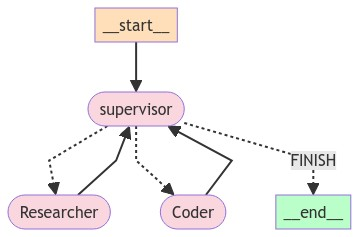

In [ ]:
# * WORKFLOW DAG

workflow = StateGraph(GraphState)

workflow.add_node("Researcher", research_node)
workflow.add_node("Coder", coder_node)
workflow.add_node("supervisor", supervisor_node)

for member in subagent_names:
    workflow.add_edge(member, "supervisor")
    
conditional_map = {'Researcher': 'Researcher', 'Coder': 'Coder', 'FINISH': END}

workflow.add_conditional_edges("supervisor", lambda x: x["next"], conditional_map)

workflow.set_entry_point("supervisor")

app = workflow.compile()

Image(app.get_graph().draw_mermaid_png())

In [ ]:
result_3 = app.invoke(
    input = {"messages": [HumanMessage(content="Find the historical prices of SPY for the last 5 years from Yahoo Finance (feel free to use the yfinance library, which is installed). Plot a daily line chart of the SPY value over time from the historical prices using python and the plotly library. Add a 50-day and 200-day simple moving average. Make sure the end date used is '2024-07-24'. Add a dateslider.")]},
    config = {"recursion_limit": 10},
)

{'next': 'Researcher'}
{'next': 'Coder'}


[*********************100%%**********************]  1 of 1 completed


{'next': 'FINISH'}


In [ ]:
result_3

{'messages': [HumanMessage(content="Find the historical prices of SPY for the last 5 years from Yahoo Finance (feel free to use the yfinance library, which is installed). Plot a daily line chart of the SPY value over time from the historical prices using python and the plotly library. Add a 50-day and 200-day simple moving average. Make sure the end date used is '2024-07-24'. Add a dateslider."),
  HumanMessage(content="To plot the historical prices of SPY (SPDR S&P 500 ETF Trust) with the specified moving averages using Python, you can use the `yfinance` library to fetch the data and the `plotly` library to create an interactive chart. Below is a step-by-step guide and code example to achieve this.\n\n### Step 1: Install Required Libraries\nMake sure you have the necessary libraries installed. You can install `yfinance` and `plotly` using pip if you haven't done so already.\n\n```bash\npip install yfinance plotly\n```\n\n### Step 2: Fetch Historical Data\nYou will fetch the historical

In [ ]:
for message in result_3['messages']:
    if message.name:
        print(f"Name: {message.name}")
    print(f"Content: {message.content}")
    print("---")
    print()

Content: Find the historical prices of SPY for the last 5 years from Yahoo Finance (feel free to use the yfinance library, which is installed). Plot a daily line chart of the SPY value over time from the historical prices using python and the plotly library. Add a 50-day and 200-day simple moving average. Make sure the end date used is '2024-07-24'. Add a dateslider.
---

Name: Researcher
Content: To plot the historical prices of SPY (SPDR S&P 500 ETF Trust) with the specified moving averages using Python, you can use the `yfinance` library to fetch the data and the `plotly` library to create an interactive chart. Below is a step-by-step guide and code example to achieve this.

### Step 1: Install Required Libraries
Make sure you have the necessary libraries installed. You can install `yfinance` and `plotly` using pip if you haven't done so already.

```bash
pip install yfinance plotly
```

### Step 2: Fetch Historical Data
You will fetch the historical data for SPY for the last 5 year

In [ ]:
result_4 = app.invoke(
    input = {"messages": [HumanMessage(content="Find the historical prices of NVDA and VIX for the last 5 years from Yahoo Finance (feel free to use the yfinance library, which is installed). Plot a daily line chart of the value over time from the historical prices using python and the plotly library. Organize the plots by using 1 column by 2 row subplots so that the dates line up and VIX is the first plot and NVDA is below. Make sure the end date used is '2024-07-24'. Add a dateslider.")]},
    config = {"recursion_limit": 10},
)

{'next': 'Researcher'}
{'next': 'Coder'}


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


{'next': 'FINISH'}


In [ ]:
result_4

{'messages': [HumanMessage(content="Find the historical prices of NVDA and VIX for the last 5 years from Yahoo Finance (feel free to use the yfinance library, which is installed). Plot a daily line chart of the value over time from the historical prices using python and the plotly library. Organize the plots by using 1 column by 2 row subplots so that the dates line up and VIX is the first plot and NVDA is below. Make sure the end date used is '2024-07-24'. Add a dateslider."),
  HumanMessage(content="To obtain the historical prices for NVDA and VIX for the last five years from Yahoo Finance, I will use the `yfinance` library in Python to download the data. Then, I will plot the daily line chart using the `plotly` library, organizing the plots in a 1x2 grid with the VIX on top and NVDA below while incorporating a date slider.\n\nBelow is the Python code that performs these tasks:\n\n```python\nimport yfinance as yf\nimport plotly.graph_objs as go\nfrom plotly.subplots import make_subpl

In [ ]:
result_4 = graph.invoke(
    input = {"messages": [HumanMessage(content="Find the historical prices of NVDA and VIX for the last 5 years from Yahoo Finance (feel free to use the yfinance library, which is installed). Plot a daily line chart of the value over time from the historical prices using python and the plotly library. Organize the plots by using 1 column by 2 row subplots so that the dates line up and VIX is the first plot and NVDA is below. Make sure the end date used is '2024-07-24'. Add a dateslider.")]},
    config = {"recursion_limit": 10},
)

{'next': 'Researcher'}
{'next': 'Coder'}


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


{'next': 'FINISH'}


In [ ]:
result_4

{'messages': [HumanMessage(content="Find the historical prices of NVDA and VIX for the last 5 years from Yahoo Finance (feel free to use the yfinance library, which is installed). Plot a daily line chart of the value over time from the historical prices using python and the plotly library. Organize the plots by using 1 column by 2 row subplots so that the dates line up and VIX is the first plot and NVDA is below. Make sure the end date used is '2024-07-24'. Add a dateslider."),
  HumanMessage(content='To obtain the historical prices for NVDA (NVIDIA Corporation) and VIX (CBOE Volatility Index) for the last five years, we can use the `yfinance` library in Python. Below is a Python code snippet that retrieves the data, processes it, and plots the requested charts using the `plotly` library.\n\n### Python Code\n\n```python\nimport yfinance as yf\nimport plotly.graph_objects as go\nfrom plotly.subplots import make_subplots\n\n# Define the tickers and date range\nnvda_ticker = "NVDA"\nvix_t

In [ ]:
for message in result_4['messages']:
    if message.name:
        print(f"Name: {message.name}")
    print(f"Content: {message.content}")
    print("---")
    print()

Content: Find the historical prices of NVDA and VIX for the last 5 years from Yahoo Finance (feel free to use the yfinance library, which is installed). Plot a daily line chart of the value over time from the historical prices using python and the plotly library. Organize the plots by using 1 column by 2 row subplots so that the dates line up and VIX is the first plot and NVDA is below. Make sure the end date used is '2024-07-24'. Add a dateslider.
---

Name: Researcher
Content: To obtain the historical prices for NVDA (NVIDIA Corporation) and VIX (CBOE Volatility Index) for the last five years, we can use the `yfinance` library in Python. Below is a Python code snippet that retrieves the data, processes it, and plots the requested charts using the `plotly` library.

### Python Code

```python
import yfinance as yf
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Define the tickers and date range
nvda_ticker = "NVDA"
vix_ticker = "^VIX"
end_date = "2024-07